In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from skimage import color
from skimage import io
from keras.utils.vis_utils import plot_model
from keras.utils import plot_model

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
#path = "T_images"                  ##############Big version
#annot = "Threads_Annotations"

In [3]:
path = "T_IM"
annot = "T_ANO" ############small version

In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
tf.test.is_built_with_cuda()

False

0
046.jpg


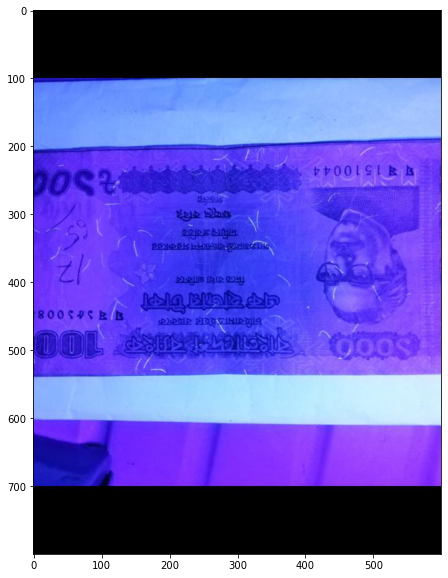

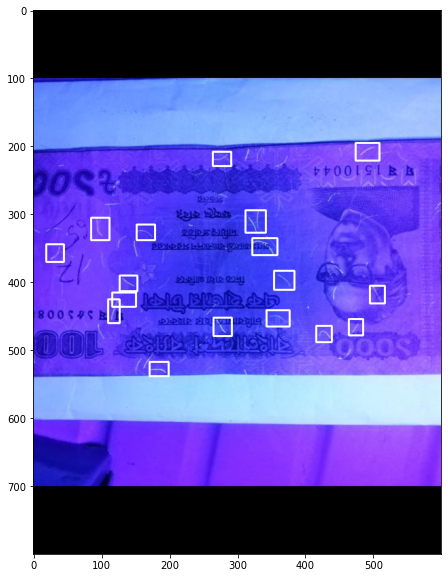

In [6]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        print(i[0])
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        df = pd.read_csv(os.path.join(annot,i))
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,255), 2)
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
        break

In [7]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

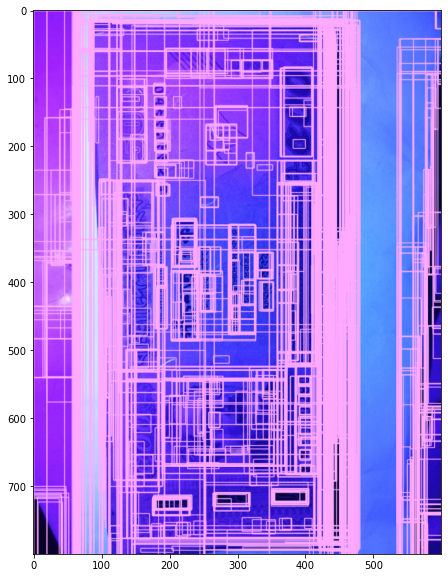

In [8]:
im = cv2.imread(os.path.join(path,"001.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (255, 170, 255), 1, cv2.LINE_AA)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(imOut,cv2.COLOR_BGR2RGB))

In [10]:
train_images=[]
train_labels=[]

In [11]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [12]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [13]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith(""):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.50:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <5:
                            if iou < 0.50:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 046.jpg
1 007.jpg
2 021.jpg
3 032.jpg
4 017.jpg
5 001.jpg
6 019.jpg
7 029.jpg
8 042.jpg
inside
9 024.jpg
10 041.jpg
11 050.jpg
12 047.jpg
13 034.jpg
14 027.jpg
15 012.jpg
16 033.jpg
17 038.jpg
inside
18 011.jpg
19 025.jpg
20 040.jpg
inside
21 005.jpg
22 004.jpg
23 016.jpg
24 006.jpg
25 009.jpg
26 002.jpg
27 035.jpg
28 044.jpg
inside
29 020.jpg
30 031.jpg
31 010.jpg
32 013.jpg
33 026.jpg
34 018.jpg
35 003.jpg
36 049.jpg
37 023.jpg
38 008.jpg
39 030.jpg
40 015.jpg
41 022.jpg
42 036.jpg
43 043.jpg
inside
44 037.jpg
45 014.jpg
46 028.jpg
47 048.jpg
48 039.jpg
inside
49 045.jpg
inside


In [16]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [17]:
X_new.shape,y_new.shape

((914, 224, 224, 3), (914,))

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test , y_train, y_test = train_test_split(X_new,y_new,test_size=0.20)

In [20]:
X_train.shape,y_train.shape

((731, 224, 224, 3), (731,))

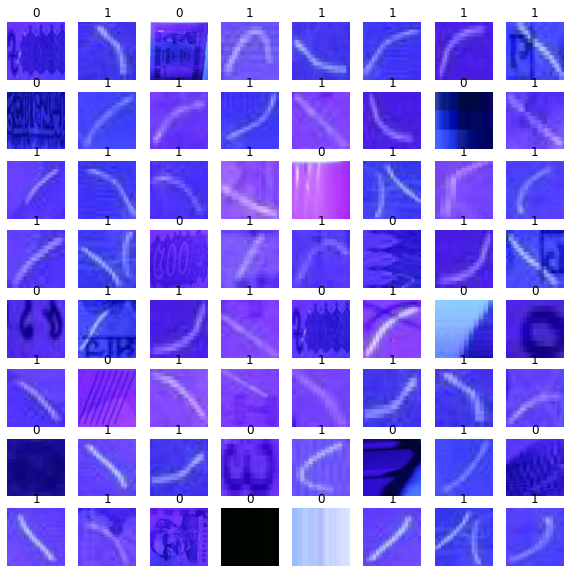

In [21]:
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(cv2.cvtColor(X_train[i],cv2.COLOR_BGR2RGB))
    plt.title(y_train[i])
    plt.axis("off")

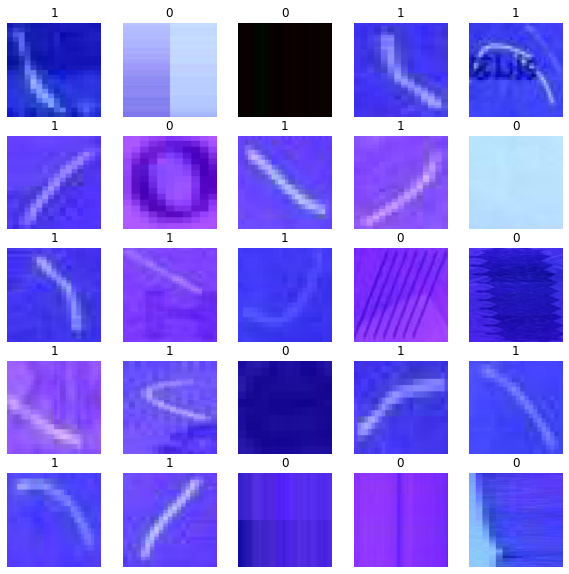

In [22]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(cv2.cvtColor(X_test[i],cv2.COLOR_BGR2RGB))
    plt.title(y_test[i])
    plt.axis("off")

In [23]:
count=0
for i in range (85) :
    if (y_train[i]==1) :
        #print(y_train[i])
        count = count+1
count

61

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D,AveragePooling2D

In [26]:
model = Sequential()

model.add(Conv2D(64, (7, 7),strides=(2, 2), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3),padding='same',strides=(2, 2)))
##############################################################
model.add(Conv2D(64, (1, 1),padding='same'))
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(3, 3),padding='same',strides=(2, 2)))
################################################################
model.add(Conv2D(128, (1, 1),padding='same'))
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(3, 3),padding='same',strides=(2, 2)))
#####################################################################
model.add(Conv2D(256, (1, 1), padding='same'))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(3, 3),padding='same',strides=(2, 2)))
#####################################################################

#########################################################################
model.add(AveragePooling2D(pool_size=(3, 3),padding='same',strides=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))

model.add(Dense(1))
model.add(Activation('sigmoid'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9472      
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        4160      
_________________________________________________________________
activation_1 (Activation)    (None, 56, 56, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       8

In [28]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [29]:
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [30]:
history = model.fit(X_train, y_train, 
                 batch_size=32, 
                 epochs=50,  
                 verbose=1,
                 validation_data=(X_test, y_test))

Epoch 1/50
23/23 [==============================] - 11s 500ms/step - loss: 16.9889 - accuracy: 0.6361 - val_loss: 2.9684 - val_accuracy: 0.7104
Epoch 2/50
23/23 [==============================] - 12s 508ms/step - loss: 1.4377 - accuracy: 0.6484 - val_loss: 0.7535 - val_accuracy: 0.7760
Epoch 3/50
23/23 [==============================] - 13s 569ms/step - loss: 0.4624 - accuracy: 0.8057 - val_loss: 0.2154 - val_accuracy: 0.9071
Epoch 4/50
23/23 [==============================] - 13s 579ms/step - loss: 0.1340 - accuracy: 0.9576 - val_loss: 0.1622 - val_accuracy: 0.9235
Epoch 5/50
23/23 [==============================] - 14s 588ms/step - loss: 0.1401 - accuracy: 0.9590 - val_loss: 0.2232 - val_accuracy: 0.9126
Epoch 6/50
23/23 [==============================] - 13s 577ms/step - loss: 0.0973 - accuracy: 0.9617 - val_loss: 0.1042 - val_accuracy: 0.9344
Epoch 7/50
23/23 [==============================] - 13s 580ms/step - loss: 0.0650 - accuracy: 0.9699 - val_loss: 0.1468 - val_accuracy: 0.939

In [31]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

In [32]:
test_acc

0.994535505771637

In [33]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


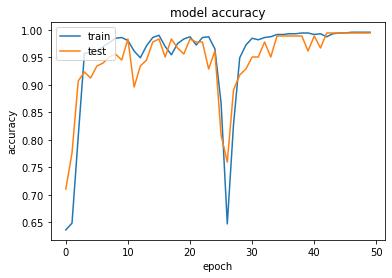

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('acuracy.png')
plt.show()

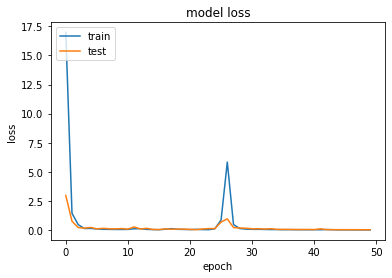

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss.png')
plt.show()

In [36]:
font = cv2.FONT_HERSHEY_SIMPLEX 
org = (50, 50) 
fontScale = 1
color = (0, 255, 255)  
thickness = 2

0.9723591
0.9858425
0.97816694
0.9894881
0.97282207
0.9883189
0.9891934
0.9821728
0.9872565
0.987531
0.9702382
0.9756783
0.97965723
0.98685443
0.9884787
0.9891394
0.98713696
0.9855483
0.9750572


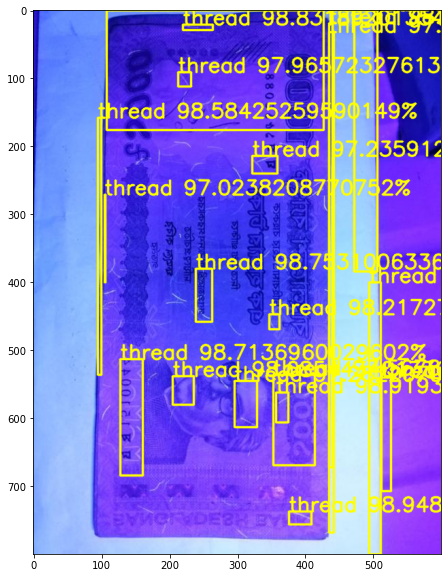

In [37]:
z=0
threshold = 0.97
for e,i in enumerate(os.listdir(path)):
    if i.startswith(""):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model.predict(img)
                #print(out[0][0])
                if out[0][0] > threshold and out[0][0] <= 0.99 :
                    print(out[0][0])
                    cv2.rectangle(imout, (x, y), (x+w, y+h), color, thickness, cv2.LINE_AA)
                    cv2.putText (imout,'thread '+str(out[0][0]*100)+'%',(x,y), font,fontScale, color, thickness, cv2.LINE_AA)
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(imout,cv2.COLOR_BGR2RGB))
        plt.savefig('result.png')
        break